In [9]:
#Importar librerias
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer

<h1> Data cleaning</h1>

Importar el csv con consumo de energia (MW) y Temperatura (C°) con el fin de:
* Visualizar datos.
* Identificar outliers y removerlos.
* Tratar los valores nulos.
* Comprobar si fueron resueltos los problemas.

In [131]:
# Importar csv que posee Consumo de energia y Temperatura de 23 provincias + CABA.
df = pd.read_csv("BASE.csv", header = 0, parse_dates = [0], index_col = 0, dayfirst=True) 
df = df.iloc[:,:6] # Seleccionar la información para la Provincia de Buenos Aires y GBA.
df['Año'] = pd.DatetimeIndex(df.index).year
df['Mes'] = pd.DatetimeIndex(df.index).month
df

,Hora,Tipo Dia,Energia BSAS,Clima BSAS,Energia GBA,Clima GBA,Año,Mes
Fecha,,,,,,,,
2018-01-01 00:00:00,0,1,1544.873,19.2,4593.287,19.2,2018,1
2018-01-01 01:00:00,1,1,1425.868,18.6,4384.859,18.6,2018,1
2018-01-01 02:00:00,2,1,1387.791,18.5,4266.546,18.5,2018,1
2018-01-01 03:00:00,3,1,1327.708,17.9,4103.462,17.9,2018,1
2018-01-01 04:00:00,4,1,1268.554,17.5,3912.347,17.5,2018,1
...,...,...,...,...,...,...,...,...
2021-07-31 19:00:00,19,7,1993.628,11.6,6638.925,11.6,2021,7
2021-07-31 20:00:00,20,7,2179.763,9.9,7349.056,9.9,2021,7
2021-07-31 21:00:00,21,7,2185.000,9.0,7698.634,9.0,2021,7


In [62]:
#Estadisticas descriptivas
df.describe()

,Hora,Tipo Dia,Energia BSAS,Clima BSAS,Energia GBA,Clima GBA,Año,Mes
count,31392.000000,31392.000000,31392.000000,31291.000000,31392.000000,31291.000000,31392.000000,31392.000000
mean,11.500000,3.902905,1711.380114,18.515474,5635.553572,18.515474,2019.324924,6.116208
std,6.922297,2.068559,239.908452,6.414347,1264.013942,6.414347,1.049593,3.386745
min,0.000000,1.000000,35.574000,0.000000,1.538000,0.000000,2018.000000,1.000000
25%,5.750000,2.000000,1542.132500,13.700000,4694.610000,13.700000,2018.000000,3.000000
50%,11.500000,4.000000,1702.990000,18.600000,5506.274000,18.600000,2019.000000,6.000000
75%,17.250000,6.000000,1868.775000,23.200000,6401.638250,23.200000,2020.000000,9.000000
max,23.000000,7.000000,2591.461000,37.800000,10478.560000,37.800000,2021.000000,12.000000


In [132]:
# Hay NaN?
df.isna().sum()

Hora              0
Tipo Dia          0
Energia BSAS      0
Clima BSAS      101
Energia GBA       0
Clima GBA       101
Año               0
Mes               0
dtype: int64

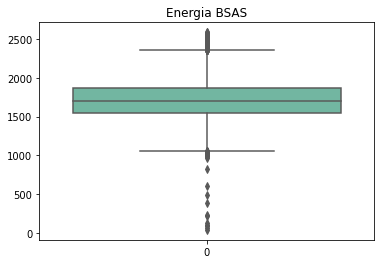

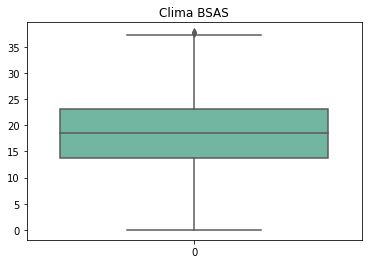

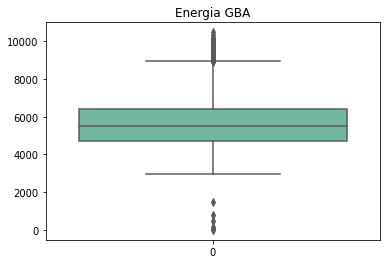

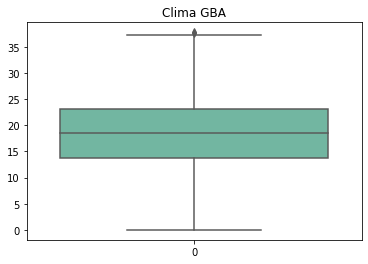

In [88]:
#Graficos de boxplot para evaluar la existencia de outliers
for column in df.columns[2:6]:
    plt.figure()
    sns.boxplot(data=df[column], palette="Set2").set_title(column)

array([[<AxesSubplot:title={'center':'Energia BSAS'}>,
        <AxesSubplot:title={'center':'Clima BSAS'}>],
       [<AxesSubplot:title={'center':'Energia GBA'}>,
        <AxesSubplot:title={'center':'Clima GBA'}>]], dtype=object)

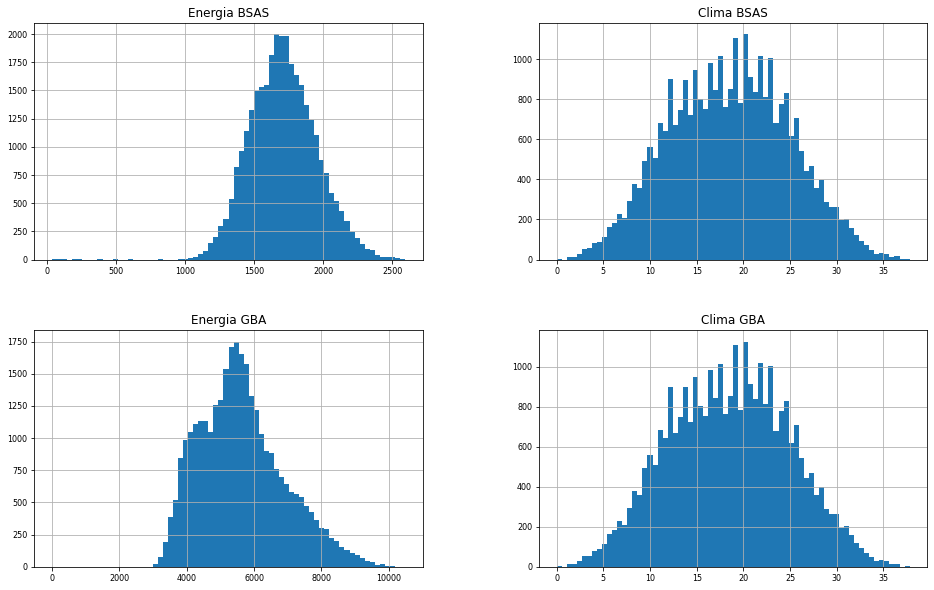

In [89]:
#Histogramas
df.iloc[:,2:6].hist(figsize=(16, 10), bins=70, xlabelsize=8, ylabelsize=8)

### Hace falta corregir la existencia de outliers para los datos de energia y valores nulos para el caso de la temperatura.
### Para el tratamiento de outliers consideramos dos opciones: z-score e IQR.\
### Al no ser distribuciones perfectamente normales en todos los casos, utilizamos el IQR.


In [133]:
#Calculo del rango intercuartil
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

Hora              11.50000
Tipo Dia           4.00000
Energia BSAS     326.64250
Clima BSAS         9.50000
Energia GBA     1707.02825
Clima GBA          9.50000
Año                2.00000
Mes                6.00000
dtype: float64


In [134]:
#Reemplazar outliers con NaN utilizando el IQR

df = df.mask((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR)), np.nan)
df.isna().sum()

Hora              0
Tipo Dia          0
Energia BSAS    192
Clima BSAS      103
Energia GBA     309
Clima GBA       103
Año               0
Mes               0
dtype: int64

#### Fueron removidos los outliers, para completar los valores nulos se prueban distintos metodos, dando mejor resultado el KNN.

In [92]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

rmse = lambda y, yhat: np.sqrt(mean_squared_error(y, yhat))
def optimize_k(data, target):
    errors = []
    for k in range(1, 20, 2):
        imputer = KNNImputer(n_neighbors=k)
        imputed = imputer.fit_transform(data)
        df_imputed = pd.DataFrame(imputed, columns=df.columns)
        
        X = df_imputed.drop(target, axis=1)
        y = df_imputed[target]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

        model = RandomForestRegressor()
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        error = rmse(y_test, preds)
        errors.append({'K': k, 'RMSE': error})
        
    return errors

In [78]:
k_errors = optimize_k(data=df, target='Energia GBA')

In [79]:
k_errors

[{'K': 1, 'RMSE': 300.9660005209868},
 {'K': 3, 'RMSE': 294.13572899089013},
 {'K': 5, 'RMSE': 292.86671880402014},
 {'K': 7, 'RMSE': 302.5453950441448},
 {'K': 9, 'RMSE': 299.1669453549278},
 {'K': 11, 'RMSE': 302.1071243835307},
 {'K': 13, 'RMSE': 287.74586331554326},
 {'K': 15, 'RMSE': 291.0246032115148},
 {'K': 17, 'RMSE': 296.966574225958},
 {'K': 19, 'RMSE': 290.60034777104664}]

In [135]:
# Completar los valores nulos utilizando KNN, con k=5
imputer = KNNImputer(n_neighbors=5)
df1 = pd.DataFrame(imputer.fit_transform(df), columns = df.columns)

In [142]:
df1.set_index(df.index, inplace=True)
df = df1
df

,Hora,Tipo Dia,Energia BSAS,Clima BSAS,Energia GBA,Clima GBA,Año,Mes
Fecha,,,,,,,,
2018-01-01 00:00:00,0.0,1.0,1544.873,19.2,4593.287,19.2,2018.0,1.0
2018-01-01 01:00:00,1.0,1.0,1425.868,18.6,4384.859,18.6,2018.0,1.0
2018-01-01 02:00:00,2.0,1.0,1387.791,18.5,4266.546,18.5,2018.0,1.0
2018-01-01 03:00:00,3.0,1.0,1327.708,17.9,4103.462,17.9,2018.0,1.0
2018-01-01 04:00:00,4.0,1.0,1268.554,17.5,3912.347,17.5,2018.0,1.0
...,...,...,...,...,...,...,...,...
2021-07-31 19:00:00,19.0,7.0,1993.628,11.6,6638.925,11.6,2021.0,7.0
2021-07-31 20:00:00,20.0,7.0,2179.763,9.9,7349.056,9.9,2021.0,7.0
2021-07-31 21:00:00,21.0,7.0,2185.000,9.0,7698.634,9.0,2021.0,7.0


#### Fueron probados tambien los siguientes metodos:

* Repetimos el proceso de visualización para identificar si fueron resueltos los problemas en las series de tiempo

In [143]:
df.isna().sum()

Hora            0
Tipo Dia        0
Energia BSAS    0
Clima BSAS      0
Energia GBA     0
Clima GBA       0
Año             0
Mes             0
dtype: int64

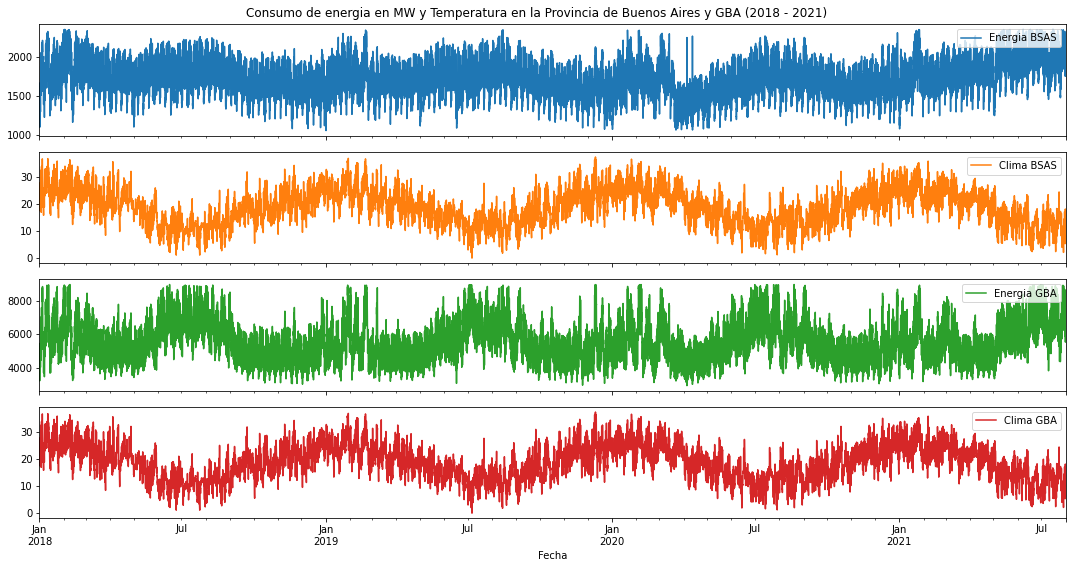

In [144]:
df[['Energia BSAS', 'Clima BSAS', 'Energia GBA', 'Clima GBA']].plot(subplots = True, figsize = (15,8))
[ax.legend(loc = 1) for ax in plt.gcf().axes]
plt.suptitle('Consumo de energia en MW y Temperatura en la Provincia de Buenos Aires y GBA (2018 - 2021)')
plt.tight_layout()
plt.subplots_adjust(top = 0.95)

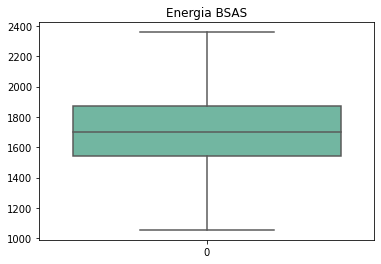

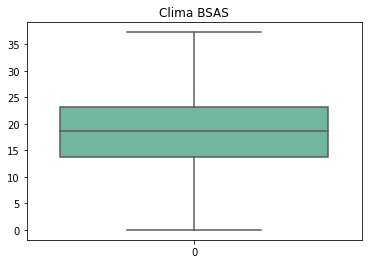

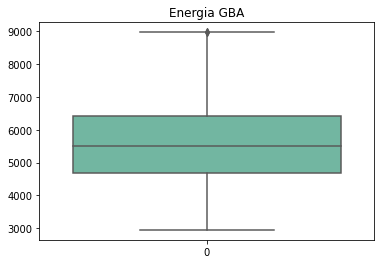

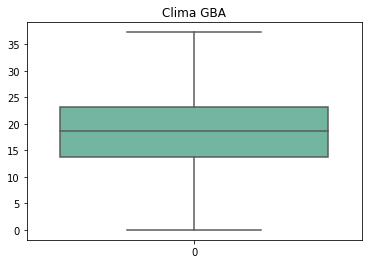

In [119]:
#Graficos de boxplot
for column in df.columns[2:6]:
    plt.figure()
    sns.boxplot(data=df[column], palette="Set2").set_title(column)

array([[<AxesSubplot:title={'center':'Energia BSAS'}>,
        <AxesSubplot:title={'center':'Clima BSAS'}>],
       [<AxesSubplot:title={'center':'Energia GBA'}>,
        <AxesSubplot:title={'center':'Clima GBA'}>]], dtype=object)

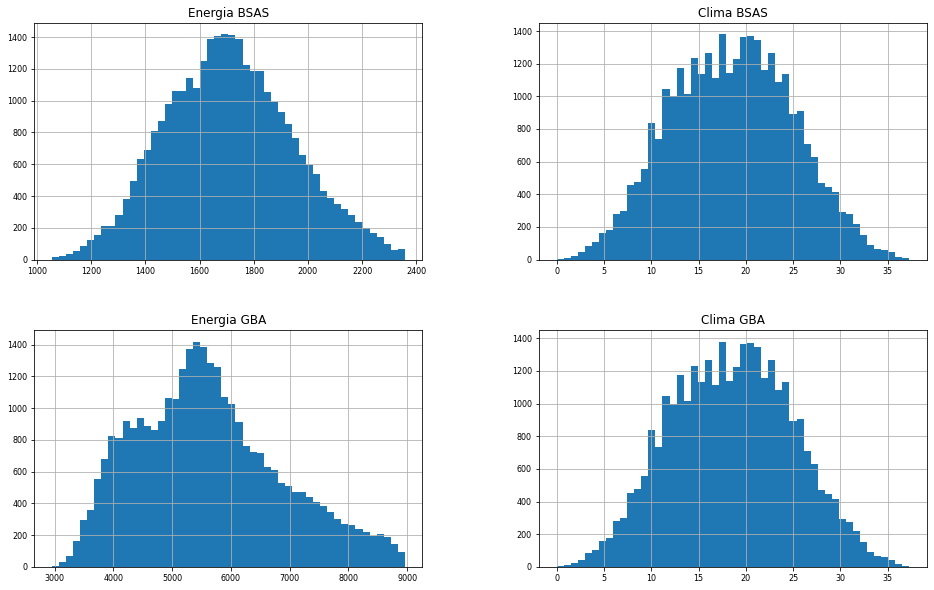

In [120]:
#Distribuciones
df.iloc[:,2:6].hist(figsize=(16, 10), bins=50, xlabelsize=8, ylabelsize=8)

In [145]:
#Exportar csv sin outliers para el modelo
df.to_csv("BASEo.csv")

<h1> Análisis de datos - GBA</h1>

Este apartado tiene como objetivo buscar insight en los datos que permitan definir algunas especificaciones del modelo

In [146]:
df

,Hora,Tipo Dia,Energia BSAS,Clima BSAS,Energia GBA,Clima GBA,Año,Mes
Fecha,,,,,,,,
2018-01-01 00:00:00,0.0,1.0,1544.873,19.2,4593.287,19.2,2018.0,1.0
2018-01-01 01:00:00,1.0,1.0,1425.868,18.6,4384.859,18.6,2018.0,1.0
2018-01-01 02:00:00,2.0,1.0,1387.791,18.5,4266.546,18.5,2018.0,1.0
2018-01-01 03:00:00,3.0,1.0,1327.708,17.9,4103.462,17.9,2018.0,1.0
2018-01-01 04:00:00,4.0,1.0,1268.554,17.5,3912.347,17.5,2018.0,1.0
...,...,...,...,...,...,...,...,...
2021-07-31 19:00:00,19.0,7.0,1993.628,11.6,6638.925,11.6,2021.0,7.0
2021-07-31 20:00:00,20.0,7.0,2179.763,9.9,7349.056,9.9,2021.0,7.0
2021-07-31 21:00:00,21.0,7.0,2185.000,9.0,7698.634,9.0,2021.0,7.0


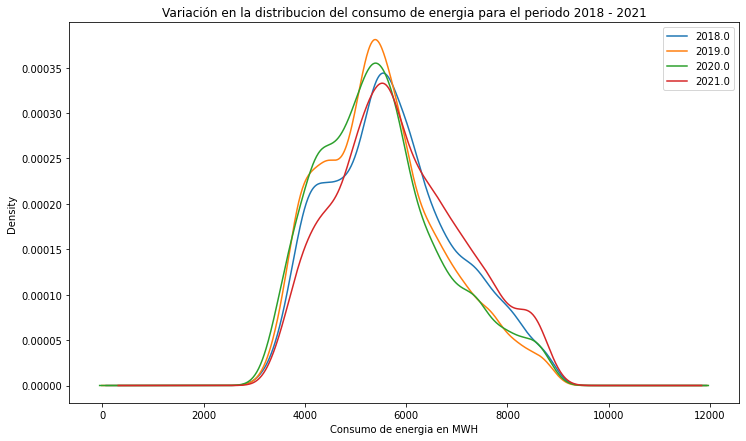

In [147]:
#Distribuciones por Año
df1 = df
for año in df1['Año'].unique():
    df1[df1['Año'] == año]['Energia GBA'].plot(kind='density', figsize = (12,7), legend = True, label = año)
    _ = plt.xlabel('Consumo de energia en MWH')
    _ = plt.title('Variación en la distribucion del consumo de energia para el periodo 2018 - 2021')

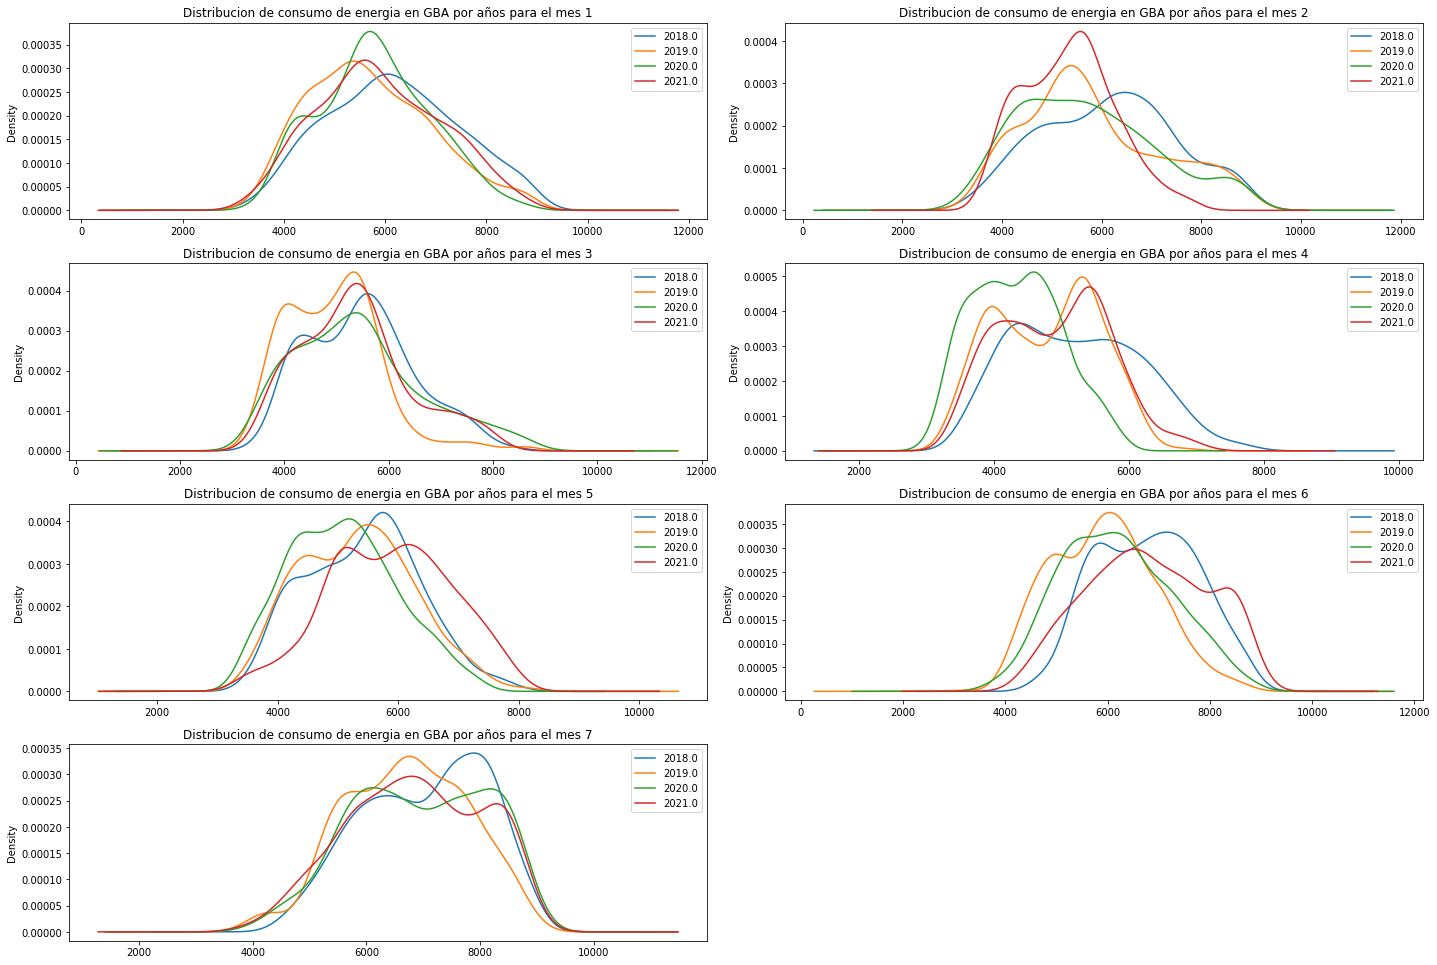

In [148]:
#Distribuciones por mes
f = plt.figure(figsize = (20,40))
mes = np.arange(1, 8) #Solo considera los primeros 7 meses del año, para los que tenemos datos en el 2021
for i, mes in enumerate(mes):
    ax = f.add_subplot(12,2,i+1)
    for j, year in enumerate(df['Año'].unique()):
        df[(df['Año'] == year) & (df['Mes'] == mes)]['Energia GBA'].\
                                plot(kind='density',  sharey=False, legend=True, label= year)
    plt.title('Distribucion de consumo de energia en GBA por años para el mes '+str(mes))
plt.tight_layout()

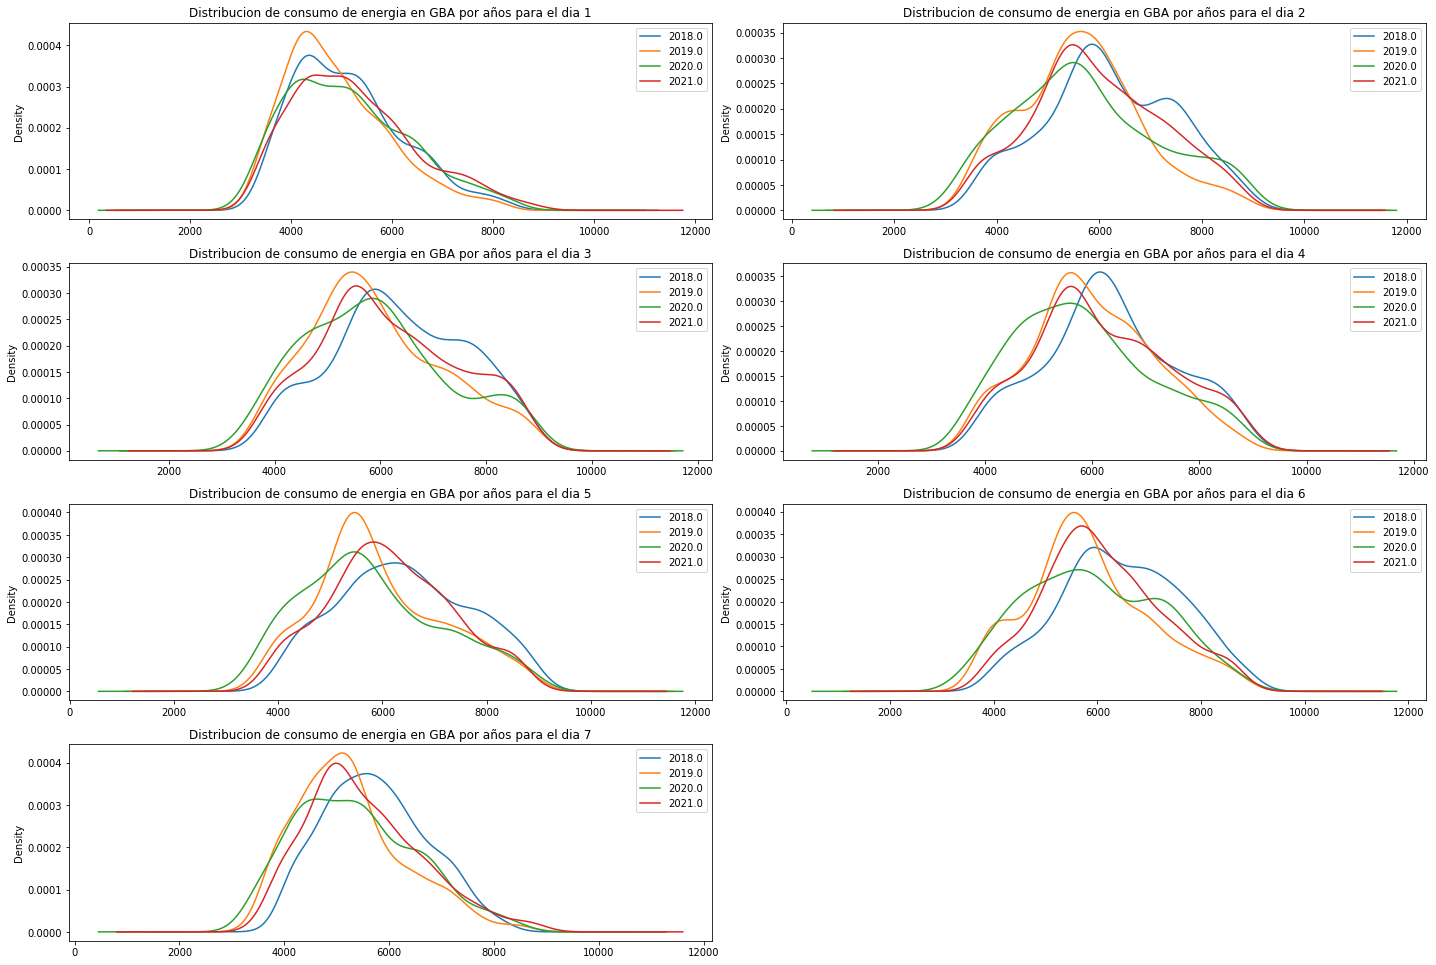

In [152]:
#Distribuciones por dia de la semana, para los primeros 7 meses del año
f = plt.figure(figsize = (20,40))
tipo_dia = np.arange(1,8) 
for i, dia in enumerate(tipo_dia):
    ax = f.add_subplot(12,2,i+1)
    for j, year in enumerate(df['Año'].unique()):
        df[(df['Año'] == year) & (df['Tipo Dia'] == dia) & (df['Mes'] < 8)]['Energia GBA'].\
                                plot(kind='density',  sharey=False, legend=True, label= year)
    plt.title('Distribucion de consumo de energia en GBA por años para el dia '+str(dia))
plt.tight_layout()

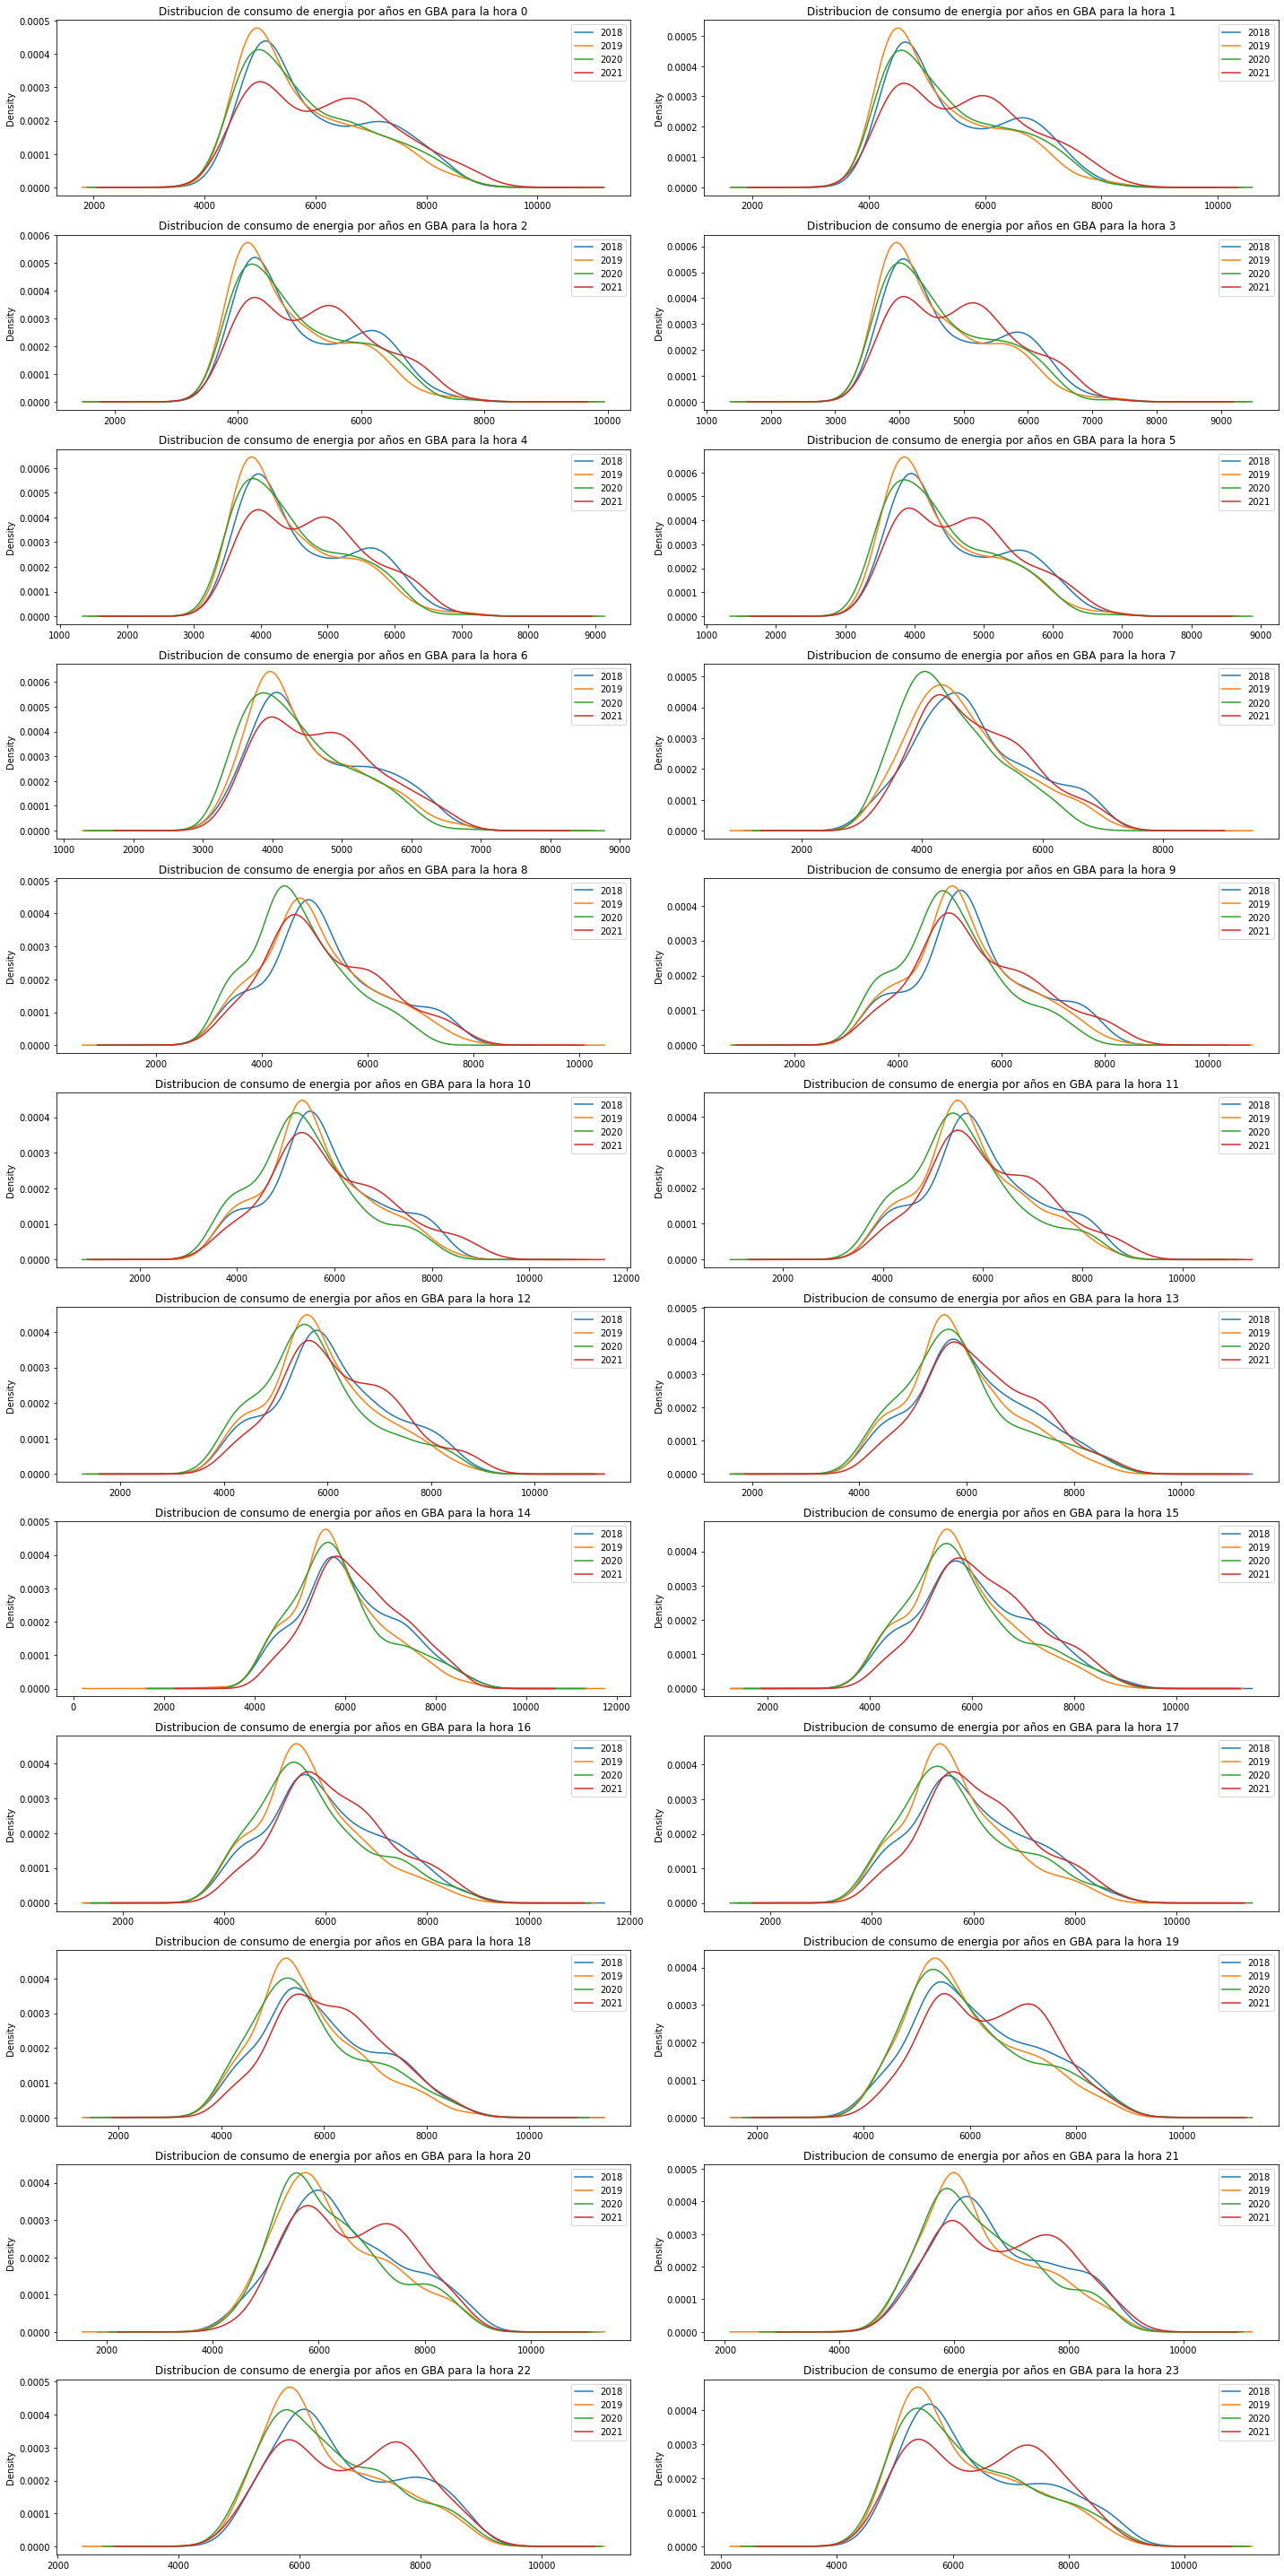

In [158]:
#Distribuciones por hora del dia
f = plt.figure(figsize = (20,40))
peak_hours = np.arange(0,24) 
for i, hour in enumerate(peak_hours):
    ax = f.add_subplot(12,2,i+1)
    for j, year in enumerate(df['Año'].unique()):
        df[(df['Año'] == year) & (df['Hora'] == hour)]['Energia GBA'].\
                                plot(kind='density',  sharey=False, legend=True, label= year)
    plt.title('Distribucion de consumo de energia por años en GBA para la hora '+str(hour))
plt.tight_layout()